## LOGISTIC REGRESSION FOR THE SEARCH OF SUPERSYMMETRIC PARTICLES

This is a task which takes use of one powerful tool in binary classification problems, the logistic regression. We are going to combine the big potential offered by machine learning algorythms with particle physics. The aim of this task is to code and train an algorythm from scratch that could help in the search of the supersymmetric particles, a theory that if confirmed, could solve some recurrent issues in Standard Model.

### THE DATASET
For this purpouse, a dataset consisting in 5 million rows of data modeled with Monte Carlo simulations is used. This events are similar to the ones obtained in high energy physics experiments, such as the ATLAS and CMS detectors at the CERN LHC. (https://archive.ics.uci.edu/ml/datasets/SUSY)

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
df = pd.read_csv("SUSY.csv", names=columns, header=None)
df.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


The dataset has 18 kinematic values (the features we are going to use). The first eight are direct measurements of final state particles and the last ten are functions of the previous ones. The latter are high-level features derived by physicists to help discriminate between two classes: signal or background process (first column). The label "1", referred as signal, corresponds to a detected new process or particle. On the other hand, the label 0 corresponds to a background process well predicted by the Standard Model. Further information about the physics behind this can be found in the following paper: Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014)

### DATA EXPLORATION
Before jumping straight to the algorythm, some prior data analysis can be made even though these 18 features do not seem very natural to anyone. One possible and intuitive way to try to discriminate signals and background processes is with histograms of all the features: one may be able to determine some ranges in which certain feature outputs 1 or 0.

First, we are going to split the data into training and testing data. We are going to use only the first 1.5 million rows for training the algorythm and the following 500000 to evaluate the results (we do not use the whole dataset due to the lack of a suitable computer that does not take too much time to process it):

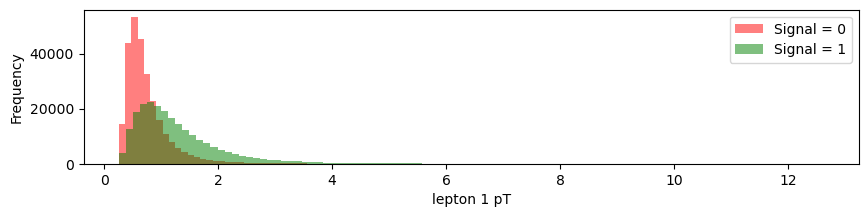

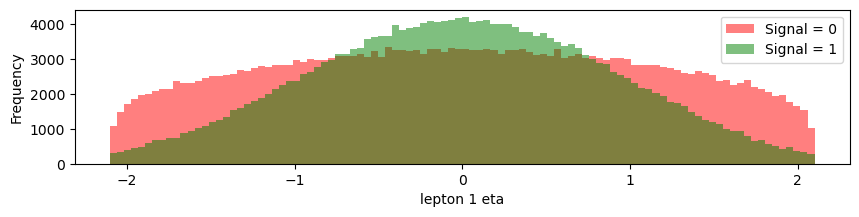

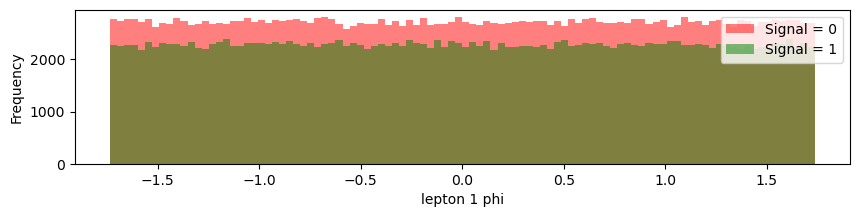

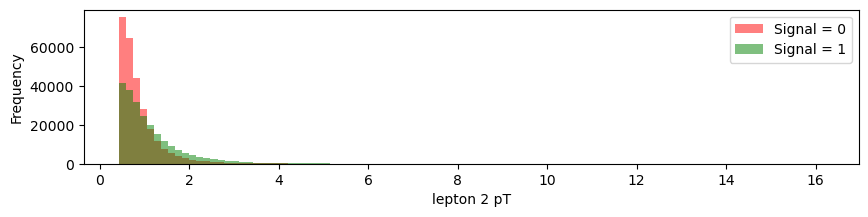

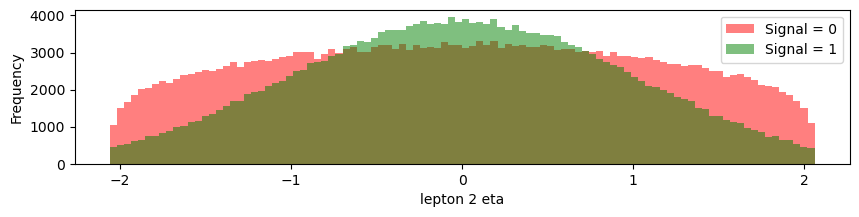

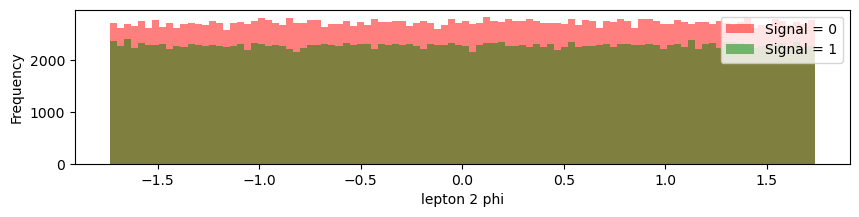

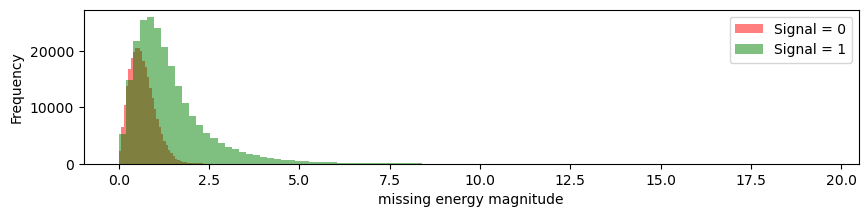

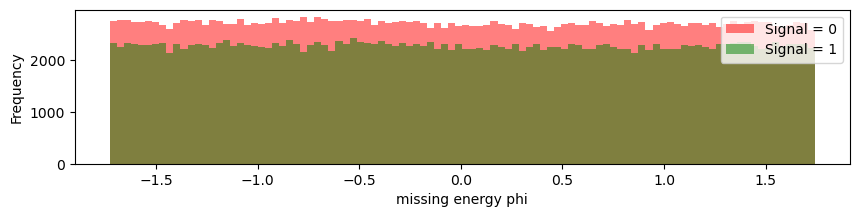

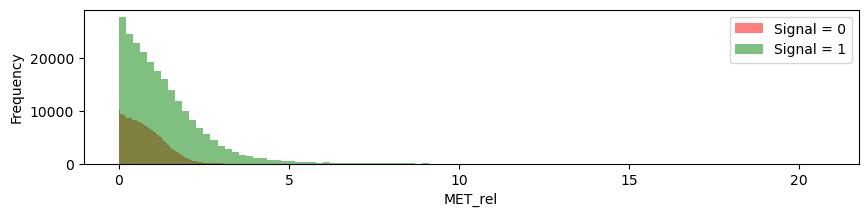

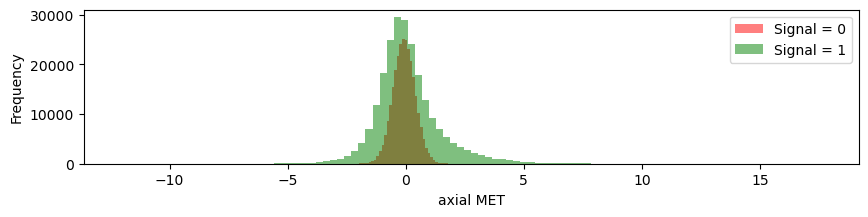

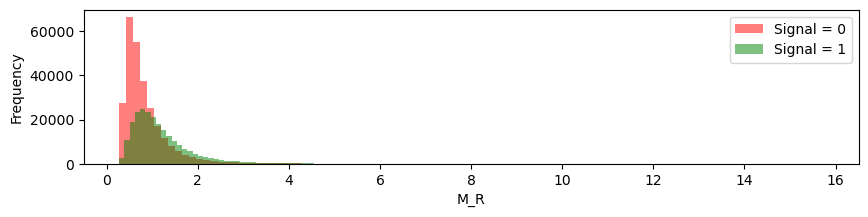

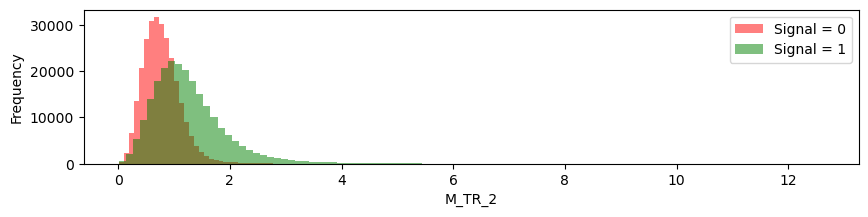

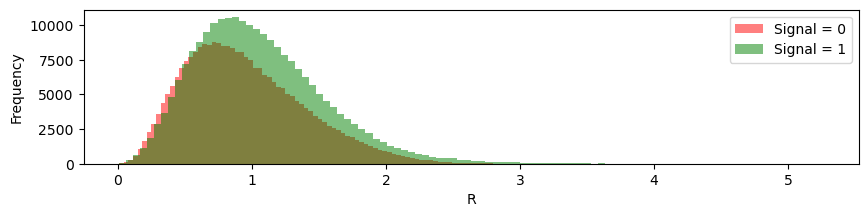

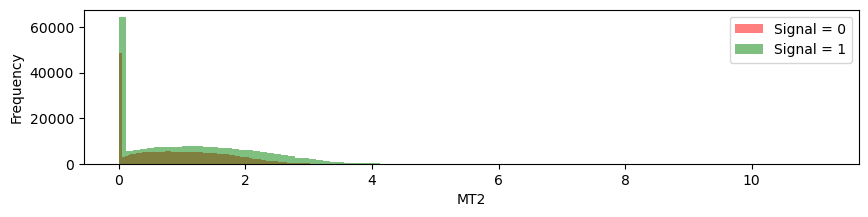

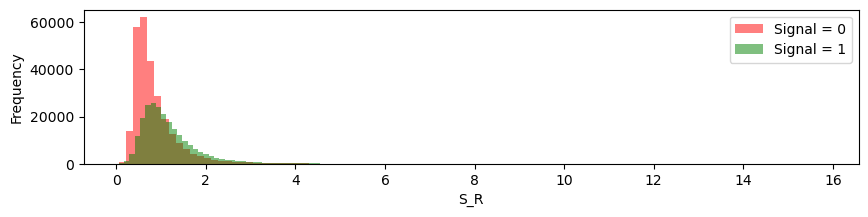

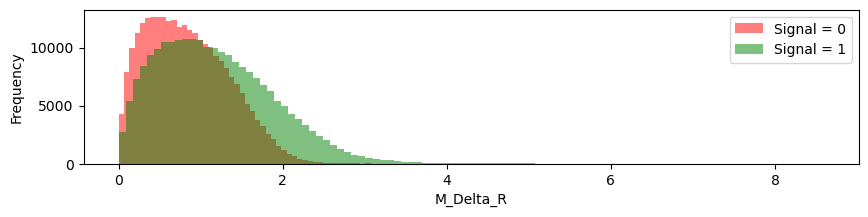

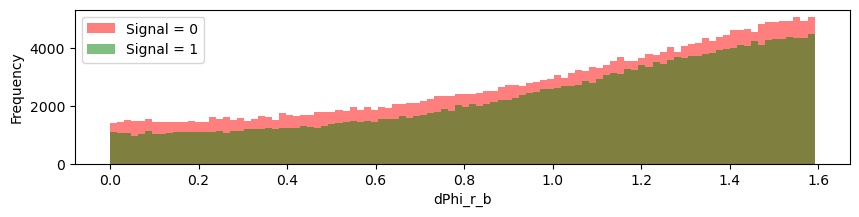

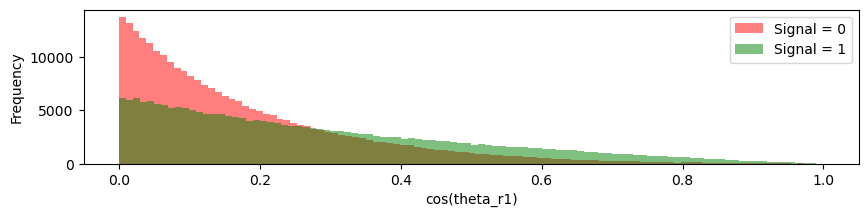

In [4]:
n_train = 1500000
n_test = 500000
n_features = 18 #number of features

df_train = df.iloc[0:n_train]
df_test = df.iloc[n_train:n_train+n_test]

#Plotting hystograms for each feature (test data only)
kwargs = dict(alpha=0.5, bins=100)
for idx,i in enumerate(columns):
    if i != "signal":
        fig = plt.figure(i)
        fig.set_size_inches(10, 2)
        plt.hist(df_test.loc[df_test.signal==0.0, i], **kwargs, color='r', label='Signal = 0')
        plt.hist(df_test.loc[df_test.signal==1.0, i], **kwargs, color='g', label='Signal = 1')
        plt.gca().set(xlabel=i, ylabel='Frequency')
        plt.legend()   

As mentioned, analysis from these histograms are not very easy and conclusive: many complex features (momentums, angles, energies, etc) play different roles here. Nevertheless, different observations can be made, for instance, the last plot shows that for larger values of cos(theta_r1) it is more likely to encounter a new particle.

### BUILDING THE ALGORYTHM

The hypothesis this algorythm follows is that data can be modeled with the sigmoid or logistic function: (https://en.wikipedia.org/wiki/Logistic_regression)

$$ P(signal=1|X)=\frac{1}{1+e^{-(X\cdot w +b)}} $$

Where X is a row matrix of the 18 features, w is a column matrix which contains 18 different parameters to determine, and b is another parameter (intercept/bias). 
We are going to assign 1.0 (signal) to events with P greater or equal to 0.5, and 0.0 (background) otherwise.

Then the task will be in this case to obtain the 19 parameters required to define the model. To accomplish that, we are going to use the well-known binary cross entropy loss function:

$$ L(w,b) = -\frac{1}{n_{train}} \sum_{i=1}^{n_{train}}\left(y^{(i)} \log \left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{y}^{(i)}\right)\right.  $$

Here, $y^{(i)}$ refers to the actual probability of an event, (either 0 or 1) and $\hat{y}^{(i)}$ is the probability predicted by the regression. So, we need to find w and b such that L is minimum. One could think of calculating some derivatives as we usually do in linear regression problems and eventually getting an analytical expression for each parameter, but since we have logarythms involved this can be a hard way to proceed. Instead, a iteritive method to obtain a minimum of L(w,b) is going to be used: the Gradient Descent (https://en.wikipedia.org/wiki/Gradient_descent). Then, the following partial derivatives are needed to be calculated:

$$\frac{\partial L(w,b)}{\partial w} = \frac{1}{n_{train}}(\hat{y}-y)\cdot X $$

$$\frac{\partial L(w,b)}{\partial b} = \frac{1}{n_{train}}(\hat{y}-y)$$

Then, a function that outputs both derivatives given a row matrix of features, their true and predicted probabilities:

In [28]:
def sigmoid(z): #sigmoid function
    return 1.0/(1.0 + np.exp(-z))

def loss(y, y_pred): #binary cross entropy loss function
    
    #to avoid the calculation of log of values very close to 0 we add a very small constant to y_pred
    epsilon=1e-10
    return -np.mean(np.array(y)*(np.log(y_pred+epsilon))+(1-np.array(y))*np.log(1-y_pred+epsilon)) #np.mean sums and divide straightforwardly as in the expression above

def derivatives(X, y, y_pred):
    
    dw = (1/n_train)*(np.dot(y_pred-np.array(y),X))
    db = np.mean(y_pred-np.array(y))
    
    return dw,db

Now we need to preprocess the data i.e normalize and stadardize the features and define proper variables. For preprocessing we are going to use sklearn package.

In [6]:
scaler = preprocessing.StandardScaler()
scaler.fit(df.iloc[0:n_train+n_test, 1:])
df_proc = scaler.transform(df.iloc[0:n_train+n_test, 1:]) #now all features have a mean of 0 and standard deviation of 1

X_train = df_proc[0:n_train]
X_test = df_proc[n_train:n_train+n_test]
y_train = df.iloc[0:n_train, 0]
y_test = df.iloc[n_train:n_train+n_test, 0]

Besides of the parameters, we need to tune some hyperparameters for our model such as epochs, learning rate, etc so it performs the most efficient way possible. In this case we are going to use cross-validation in order to find the best performing hyperparameters. The train function, then:

In [7]:
def train(X, y, lr, epochs, batch_size):
    
    #initializing
    w = np.zeros((n_features,1))
    w = [x[0] for x in w] #fixing formats
    b = 0.0
    losses = []
    
    for i in range(epochs):
        for j in range(n_train//batch_size):
            
            #Choosing the corresponding rows for batch j
            index_i = j*batch_size
            index_f = index_i + batch_size
            x_it = X[index_i:index_f]
            y_it = y[index_i:index_f]
            
            #Evaluating probabilities for current parameters
            y_pred_it = sigmoid(np.dot(x_it, w) + b)
            
            #We get the gradients for current predictions
            w_aux, b_aux = derivatives(x_it, y_it, y_pred_it)

            #We set the new parameters
            w -= lr*w_aux
            b -= lr*b_aux
            
            
        if(n_train%batch_size != 0):
            
            #how many rows would the last batch have?
            n_left = n_train - (n_train//batch_size)*batch_size
            #we apply the same algorythm for only this batch
            x_it = X[n_left:]
            y_it = y[n_left:]
            y_pred_it = sigmoid(np.dot(x_it, w) + b)
            w_aux, b_aux = derivatives(x_it, y_it, y_pred_it)
            w -= lr*w_aux
            b -= lr*b_aux
            
        #we save the loss in each epoch
        losses.append(loss(y, sigmoid(np.dot(X,w)+b)))
        
    return w,b,losses
            

Now we are going to create a function that can help us tune hyperparameters. This process is known as grid search: we try different values for each hyperparameter and watch how does the model behaves to them. Then we would choose the values that offer an equilibrium between accuracy and training time.

In [8]:
def predict(X, w, b): #once the model is trained we can predict the labels for signal
    probs = sigmoid(np.dot(X,w)+b)
    preds = []
    for i in probs:
        if i >= 0.5:
            preds.append(1.0)
        else:
            preds.append(0.0)
    
    return probs, preds

def accuracy(y, y_pred): #function to evaluate the results
    return np.sum(y == y_pred)/len(y)

def grid_search_inbetween(lrr, n_epoch, batt, x_train, y_train, x_test, y_test):
    
    t1 = time.process_time()
    ww, bb, loos = train(x_train, y_train, lrr, n_epoch, batt)
    y_pred_probs, y_pred = predict(x_test, ww, bb)
    accuracyy = accuracy(y_test, y_pred)
    t2 = time.process_time()
    df_results.loc[len(df_results.index)] = [lrr, n_epoch, batt, accuracyy, t2-t1]
    return

def grid_search(X_train, y_train, X_test, y_test):
    
    #we define the range of hyperparameters we want to try
    lrs = [0.1, 1, 2]
    epochs = [10, 20]
    batch_sizes = [50, 25, 10]
    
    for l in lrs:
        for e in epochs:
            for bat in batch_sizes:                
                grid_search_inbetween(l, e, bat, X_train, y_train, X_test, y_test)             
            grid_search_inbetween(l, e, bat, X_train, y_train, X_test, y_test)            
        grid_search_inbetween(l, e, bat, X_train, y_train, X_test, y_test)
        
    return
                

In [352]:
#for result visualization we create a dataframe for later
#rows of the dataframe are appended through the grid_search function
df_results =  pd.DataFrame(columns=["Learning rate", "Number of epochs", "Batch size", "Accuracy", "Working time (s)"], index=None)

grid_search(X_train, y_train, X_test, y_test)

In [353]:
df_results

,Learning rate,Number of epochs,Batch size,Accuracy,Working time (s)
0,0.1,10.0,50.0,0.728840,33.359375
1,0.1,10.0,25.0,0.729574,60.765625
2,0.1,10.0,10.0,0.731080,149.250000
3,0.1,10.0,10.0,0.731080,150.171875
4,0.1,20.0,50.0,0.740530,62.000000
5,0.1,20.0,25.0,0.740844,121.578125
6,0.1,20.0,10.0,0.741656,306.062500
7,0.1,20.0,10.0,0.741656,296.437500
8,0.1,20.0,10.0,0.741656,298.500000
9,1.0,10.0,50.0,0.766476,30.875000


From the results of the search grid we can realize that:
    
· The larger is the learning rate the better the accuracy. This may be due to the nature of the loss function, which is logarythmic and hence it has a large decreasing area, so the larger the learning rate, the faster we slide down to smaller values of the loss function. We see that the learning rate does not impact significantly on the working time, so 

· The smaller is the batch_size, the better the accuracy. This is because this way we prevent overfitting (the algorythm does not learn too much about the behaviour of the training data), but at the price of a big increase of the working time. If we decrease the size of the batches to train at a time, we will encounter with a greater number of trainings and hence processing time.

· Number of epochs seem to increase the accuracy a bit, with the price of an increase of 30s in the training process. In this table is not reflected, but increasing this number even more does not reflect a significant increase on the accuracy.

Then, from all the conclusiones above, the most efficient model can be trained with the following hyperparameters:

In [25]:
w, b, losses = train(X_train, y_train, 3, 20, 50) #learning rate:3, epochs:20, batch_size:50
y_pred_probs, y_pred = predict(X_test, w, b)
print("Accuracy:", accuracy(y_test, y_pred))

Accuracy: 0.782192


An accuracy of 78% for this model is quite decent, and maybe helpful in the search of supersymmetric particles.